<a href="https://colab.research.google.com/github/diegoramfin/PCA-Based-Portfolio-Risk-Decomposition/blob/main/Portfolio_Risk_Decomposition_Using_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intial Portfolio Risk Research Decomposition

Using Ledoit-Wolf along with Eigen decompositon we find covariance between assets, and the factor loadings.

In [128]:
!pip install yfinance

In [129]:
# Intial Market Data Grab

import yfinance as yf
import pandas as pd
import numpy as np

tickers = ['AAPL','MSFT','GOOGL','AMZN','TSLA','JPM','JNJ','XOM','PG','NVDA']
data = yf.download(tickers, start='2021-01-01', end='2025-01-01', auto_adjust=False)['Adj Close']
prices = data.dropna(how='all')
returns = np.log(prices / prices.shift(1)).dropna()
valid_assets = returns.columns[returns.isnull().mean() < 0.5]
returns = returns[valid_assets].dropna()
returns.head()

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,NVDA,PG,TSLA,XOM
Date,,,,,,,,,,
2021-01-05,0.012288,0.009955,0.008032,0.011689,0.005427,0.000964,0.021967,0.006365,0.007291,0.047068
2021-01-06,-0.034241,-0.025212,-0.009917,0.009366,0.045887,-0.026272,-0.060762,0.010471,0.027995,0.025197
2021-01-07,0.033554,0.007549,0.029431,0.003373,0.032311,0.028060,0.056220,-0.009390,0.076448,0.007815
2021-01-08,0.008594,0.006475,0.013152,-0.002060,0.001104,0.006074,-0.005053,-0.000432,0.075481,0.011060
2021-01-11,-0.023523,-0.021754,-0.023377,-0.004195,0.014814,-0.009746,0.025635,-0.006796,-0.081442,0.029905


In [130]:
# Covariance Estimation
'''
Calculates the covariance matrix of the asset returns using the Ledoit-Wolf method.
'''

from sklearn.covariance import LedoitWolf

lw = LedoitWolf().fit(returns.values)
cov_matrix = lw.covariance_
cols = returns.columns
N = len(cols)

In [131]:
#Eigen Decomposition
'''
This cell performs eigen decomposition on the covariance matrix to get eigenvalues and eigenvectors, and calculates factor loadings.
'''

from pickle import load

import numpy.linalg as la

eigvals, eigvecs = la.eigh(cov_matrix)
eigvals = eigvals[::-1]
eigvecs = eigvecs[:, ::-1]

explained_var_ratio = eigvals / eigvals.sum()


factor_loadings = pd.DataFrame(
    eigvecs,
    index = returns.columns,
    columns=[f'PC{i+1}' for i in range (len(returns.columns))]
)

factor_loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Ticker,,,,,,,,,,
AAPL,-0.245117,-0.096219,0.201255,0.102540,-0.364642,0.255060,-0.376099,-0.671454,0.295688,-0.043454
AMZN,-0.325648,-0.234500,0.313741,0.375459,0.627351,-0.329669,-0.268257,0.054387,0.144718,-0.038036
GOOGL,-0.270596,-0.231481,0.298540,0.275978,-0.122031,0.364374,0.692253,0.179014,0.218505,-0.035203
JNJ,-0.008745,-0.024629,0.201777,-0.003614,-0.350404,-0.185122,-0.208403,0.376843,0.274931,0.735192
JPM,-0.117823,-0.047551,0.331480,-0.348165,-0.183776,-0.680843,0.374502,-0.318051,-0.109786,-0.044468


In [132]:
#Portfolio Variance & Risk Contribution
'''
This cell calculates the portfolio variance and the contribution of each principal component to the portfolio risk.
'''

weights = np.full(N, 1/N)

#Portfolio Variance
port_var = float(weights.T @ cov_matrix @ weights)

# Absolute Factor Contributions
w_f = eigvecs.T @ weights
pc_risk_contrib = (w_f**2) * eigvals
pc_risk_contrib = pc_risk_contrib / pc_risk_contrib.sum() * port_var


# Transform weights into factor space: w_f = Q^T w, where Q = eigvecs
# Different Approach to Absolute Factor but done to show creativity of approaches

Q = eigvecs                           # (N, N)
w_f = Q.T @ weights                   # (N,)
factor_contrib = (w_f**2) * eigvals
factor_contrib_ratio = factor_contrib / factor_contrib.sum()


print(f"\nPortfolio variance: {port_var:.6e}")

print("Absolute Factor Contributions (Scaled in Proportion of Total Port Var):")
for i in range(len(pc_risk_contrib)):
    print(f"  PC{i+1}: {pc_risk_contrib[i]:.6e}")

print("Relative Factor Contribution ratios (% of Total Port Var):")
for i in range(len(factor_contrib_ratio)):
    print(f"  PC{i+1}: {factor_contrib_ratio[i]:.4f}")


Portfolio variance: 1.630608e-04
Absolute Factor Contributions (Scaled in Proportion of Total Port Var):
  PC1: 1.481836e-04
  PC2: 3.085664e-06
  PC3: 9.528703e-06
  PC4: 5.767029e-07
  PC5: 1.180933e-06
  PC6: 1.087146e-07
  PC7: 1.810542e-07
  PC8: 2.072813e-07
  PC9: 4.592288e-09
  PC10: 3.598127e-09
Relative Factor Contribution ratios (% of Total Port Var):
  PC1: 0.9088
  PC2: 0.0189
  PC3: 0.0584
  PC4: 0.0035
  PC5: 0.0072
  PC6: 0.0007
  PC7: 0.0011
  PC8: 0.0013
  PC9: 0.0000
  PC10: 0.0000


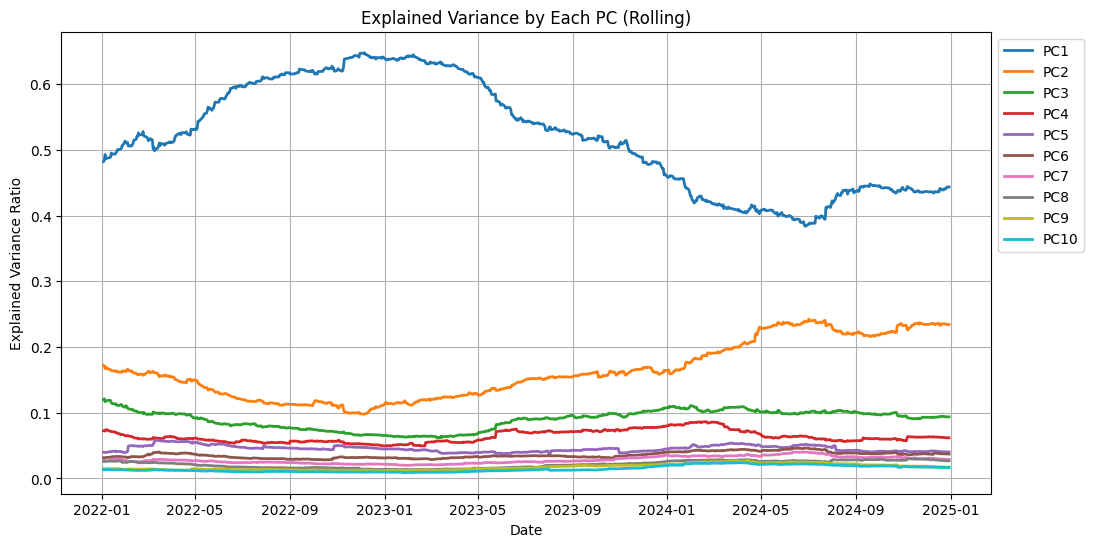

In [133]:
# Rolling Eigen Decomposition on Ledoit–Wolf Covariance

import matplotlib.pyplot as plt
import numpy as np

window = 252
rolling_explained_var = []
rolling_idx = []

for end in range(window, len(returns)):
    sub = returns.iloc[end-window:end]
    # shrinkage covariance per window
    lw = LedoitWolf().fit(sub.values)
    C = lw.covariance_
    # eigen on C
    vals, vecs = la.eigh(C)
    vals = vals[::-1]
    # explained variance ratio for this window
    evr = vals / vals.sum()
    rolling_explained_var.append(evr)
    rolling_idx.append(sub.index[-1])

rolling_explained_var = pd.DataFrame(rolling_explained_var,
                                     index=pd.DatetimeIndex(rolling_idx),
                                     columns=[f'PC{i+1}' for i in range(len(returns.columns))])

plt.figure(figsize=(12,6))
for col in rolling_explained_var.columns:
    plt.plot(rolling_explained_var[col], label=col, linewidth=2)
plt.title("Explained Variance by Each PC (Rolling)")
plt.xlabel("Date")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [134]:
# Factor Returns via Projection


R = returns.values                    # (T, N)
F = R @ eigvecs                       # (T, N) factor returns (PC1..PCN)
factor_returns = pd.DataFrame(F, index=returns.index, columns=[f"PC{i+1}" for i in range(N)])


F_scaled = pd.DataFrame(F / np.sqrt(eigvals),                 # not required for most reporting
                        index=returns.index,
                        columns=[f"PC{i+1}" for i in range(N)])

factor_returns.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Date,,,,,,,,,,
2021-01-05,-0.028159,-0.013534,0.023749,-0.034831,0.004515,0.013644,-0.011802,0.008989,0.009304,0.002576
2021-01-06,0.034530,0.063576,0.043293,-0.033267,-0.005192,-0.029250,0.026532,0.013329,-0.002319,-0.005049
2021-01-07,-0.107649,0.013381,0.000733,-0.017895,-0.018334,0.000821,0.014743,-0.016425,-0.006120,0.009822
2021-01-08,-0.054062,0.053900,0.013955,0.000705,0.002315,0.010715,0.003929,0.003457,-0.001739,-0.001672
2021-01-11,0.055422,-0.062399,-0.013777,-0.052969,0.008149,-0.006968,0.001556,0.000215,-0.007405,0.001613


In [135]:
Sigma_w = cov_matrix @ weights
mcr = Sigma_w / np.sqrt(port_var)
ccr = weights * mcr * np.sqrt(port_var)
mcr_df = pd.DataFrame({"MCR": mcr, "CCR": ccr}, index=cols).sort_values("CCR", ascending=False)
mcr_df.head()


,MCR,CCR
Ticker,,
TSLA,0.026380,0.000034
NVDA,0.025302,0.000032
AMZN,0.016913,0.000022
GOOGL,0.014661,0.000019
AAPL,0.013098,0.000017


In [136]:
# Low-Rank Covariance Approximation

threshold = 0.75  # retain 75% of variance; tune to liking
cum = np.cumsum(explained_var_ratio)
k = int(np.searchsorted(cum, threshold) + 1)

# Low-rank covariance: Q_k diag(eigvals_k) Q_k^T

Qk = Q[:, :k]
Lk = np.diag(eigvals[:k])
cov_lowrank = Qk @ Lk @ Qk.T

print(f"Selected k={k} PCs covering {cum[k-1]:.1%} of total variance.")


Selected k=3 PCs covering 77.4% of total variance.


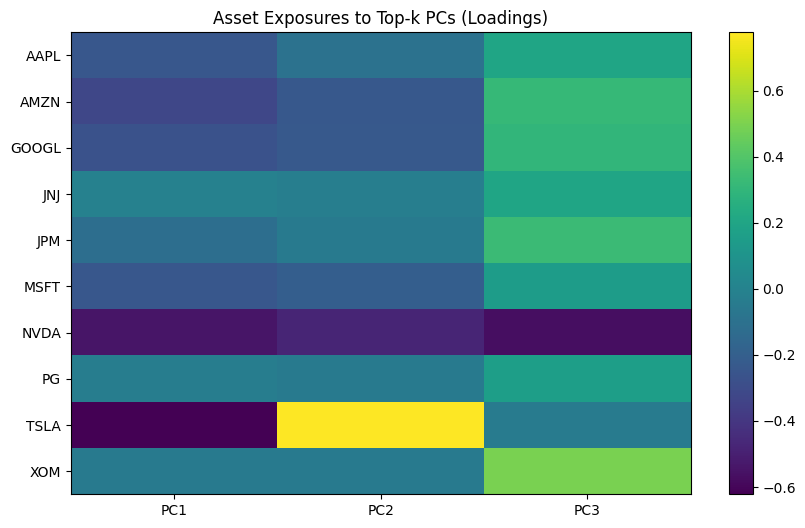

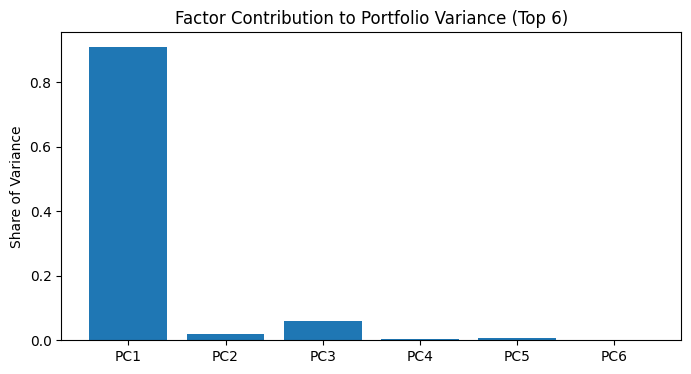

In [137]:
# --- Loadings Heatmap for top-k PCs ---
import matplotlib.pyplot as plt

topk_load = pd.DataFrame(Qk, index=cols, columns=[f"PC{i+1}" for i in range(k)])
topk_load.sort_index(inplace=True)

plt.figure(figsize=(10, max(6, int(N*0.25))))
plt.imshow(topk_load.values, aspect='auto')
plt.colorbar()
plt.yticks(range(len(topk_load.index)), topk_load.index)
plt.xticks(range(k), topk_load.columns)
plt.title("Asset Exposures to Top-k PCs (Loadings)")
plt.show()

# --- Factor contribution bar chart ---
plt.figure(figsize=(8,4))
plt.bar([f"PC{i+1}" for i in range(6)], factor_contrib_ratio[:6])
plt.title("Factor Contribution to Portfolio Variance (Top 6)")
plt.ylabel("Share of Variance")
plt.show()


# Factors Deep Dive
In this section we seek to identify what each factor is in relation to the market. Correlation allows us to identify how they are related to certain market indicators. Such as Oil (WTI), Dollar (DXY), GSPC (SP500).

In [138]:
# Identify relevant market factors

market_factors_tickers = ['^GSPC', 'XLK', 'VUG', 'TLT', 'WTI', 'DX-Y.NYB']
print(market_factors_tickers)

['^GSPC', 'XLK', 'VUG', 'TLT', 'WTI', 'DX-Y.NYB']


In [139]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download market factor data
market_data = yf.download(market_factors_tickers, start=returns.index.min(), end=returns.index.max(), auto_adjust=False)['Adj Close']

# Calculate logarithmic returns
market_returns = np.log(market_data / market_data.shift(1))

# Align market factor returns with asset returns and handle missing values
market_returns = market_returns.reindex(returns.index).dropna()

# Display the first few rows of the market factor returns
market_returns.head()

[*********************100%***********************]  6 of 6 completed


Ticker,DX-Y.NYB,TLT,VUG,WTI,XLK,^GSPC
Date,,,,,,
2021-01-06,0.001006,-0.020741,-0.011004,0.016737,-0.017396,0.005694
2021-01-07,0.003345,-0.008854,0.022833,-0.008333,0.026598,0.014738
2021-01-08,0.003001,-0.003233,0.010640,0.012474,0.006445,0.005477
2021-01-11,0.004872,-0.001654,-0.013555,0.008230,-0.008294,-0.006576
2021-01-12,-0.005427,-0.000795,-0.001935,0.055791,-0.004792,0.000416


In [140]:
# Concatenate factor returns and market returns
combined_returns = pd.concat([factor_returns, market_returns], axis=1)

# Calculate the correlation matrix
factor_market_correlation = combined_returns.corr().loc[factor_returns.columns, market_returns.columns]

# Display the correlation matrix
display(factor_market_correlation)

Ticker,DX-Y.NYB,TLT,VUG,WTI,XLK,^GSPC
PC1,0.269192,-0.061986,-0.913387,-0.146543,-0.878431,-0.839519
PC2,0.070745,-0.011325,-0.260387,-0.037281,-0.308297,-0.254336
PC3,-0.130169,-0.078171,0.167409,0.360344,0.086172,0.324309
PC4,0.086746,0.179169,0.066186,-0.477728,0.008784,-0.092416
PC5,0.095745,-0.053784,-0.077258,0.192006,-0.148128,-0.157044
PC6,0.039374,0.032980,-0.006244,0.245179,0.037786,-0.088302
PC7,0.050534,-0.118883,-0.050339,-0.019586,-0.100339,-0.054607
PC8,-0.011670,0.088865,-0.036552,-0.009808,-0.101297,0.003387
PC9,-0.036342,0.075429,-0.035201,-0.029547,-0.093891,-0.023061
PC10,0.037378,-0.022234,-0.014139,-0.006184,-0.000370,-0.017436


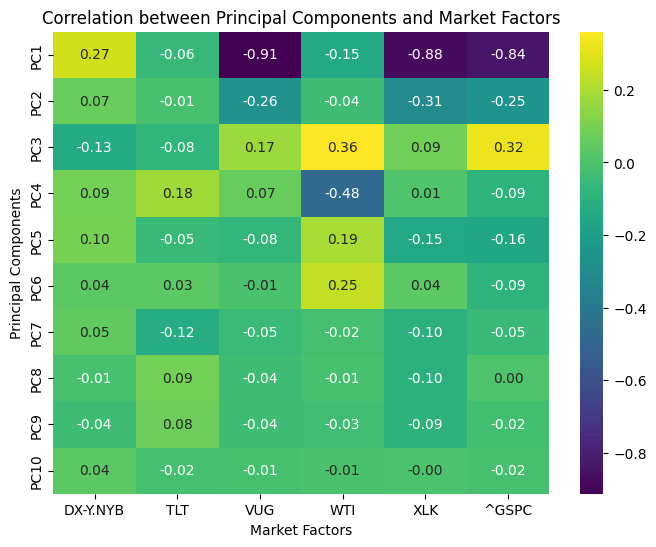

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(factor_market_correlation, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation between Principal Components and Market Factors")
plt.xlabel("Market Factors")
plt.ylabel("Principal Components")
plt.show()

In [142]:
'''
This cell prints out which PCs are strongly correlated by which Market Factors on an absolute scale.
'''
print("Principal Component Interpretation based on Market Factor Correlation:")
for pc in factor_market_correlation.index:
    highest_corr_factor = factor_market_correlation.loc[pc].abs().idxmax()
    highest_corr_value = factor_market_correlation.loc[pc, highest_corr_factor]
    print(f"{pc}: Highest absolute correlation with {highest_corr_factor} ({highest_corr_value:.4f})")

Principal Component Interpretation based on Market Factor Correlation:
PC1: Highest absolute correlation with VUG (-0.9134)
PC2: Highest absolute correlation with XLK (-0.3083)
PC3: Highest absolute correlation with WTI (0.3603)
PC4: Highest absolute correlation with WTI (-0.4777)
PC5: Highest absolute correlation with WTI (0.1920)
PC6: Highest absolute correlation with WTI (0.2452)
PC7: Highest absolute correlation with TLT (-0.1189)
PC8: Highest absolute correlation with XLK (-0.1013)
PC9: Highest absolute correlation with XLK (-0.0939)
PC10: Highest absolute correlation with DX-Y.NYB (0.0374)


In [143]:
'''
This cell looks at which are the strongest Market Factors across the 10 loadings.
'''
def pc_summary_table(factor_market_correlation, explained_variance_ratio=None, top_n=3):
    rows = []

    for pc in factor_market_correlation.index:
        row = factor_market_correlation.loc[pc].dropna()
        top_factors = row.abs().nlargest(top_n).index
        for f in top_factors:
            ve = explained_variance_ratio.loc[pc] if isinstance(explained_variance_ratio, pd.Series) else None
            rows.append({
                "PC": pc,
                "Variance_Explained": ve,
                "Factor": f,
                "Correlation": row[f],
                "Absolute Correlation:": abs(row[f])
            })
    return pd.DataFrame(rows)

# Convert explained_var_ratio to a pandas Series before passing it to the function
explained_var_ratio_series = pd.Series(explained_var_ratio, index=factor_market_correlation.index)

summary_df = pc_summary_table(factor_market_correlation, explained_var_ratio_series, top_n=6)
print(summary_df)

      PC  Variance_Explained    Factor  Correlation  Absolute Correlation:
0    PC1            0.527829       VUG    -0.913387               0.913387
1    PC1            0.527829       XLK    -0.878431               0.878431
2    PC1            0.527829     ^GSPC    -0.839519               0.839519
3    PC1            0.527829  DX-Y.NYB     0.269192               0.269192
4    PC1            0.527829       WTI    -0.146543               0.146543
5    PC1            0.527829       TLT    -0.061986               0.061986
6    PC2            0.160440       XLK    -0.308297               0.308297
7    PC2            0.160440       VUG    -0.260387               0.260387
8    PC2            0.160440     ^GSPC    -0.254336               0.254336
9    PC2            0.160440  DX-Y.NYB     0.070745               0.070745
10   PC2            0.160440       WTI    -0.037281               0.037281
11   PC2            0.160440       TLT    -0.011325               0.011325
12   PC3            0.086

In [144]:
'''
This cells prints out the Weighted Influence of each Market Factor
'''

def factor_influence(summary_df):
    df = summary_df.copy()
    if "Variance_Explained" in df and df["Variance_Explained"].notna().any():
        # Use the correct column name 'Absolute Correlation:'
        df["Weighted_Influence"] = df["Variance_Explained"] * df["Absolute Correlation:"]
    else:
        # Use the correct column name 'Absolute Correlation:'
        df["Weighted_Influence"] = df["Absolute Correlation:"]  # fallback
    return (
        # Remove 'Factor_Label' as it does not exist in summary_df
        df.groupby("Factor")["Weighted_Influence"]
          .sum()
          .sort_values(ascending=False)
          .reset_index()
    )


influence_df = factor_influence(summary_df)
print(influence_df.head(10))  # Top 10 most influential factors across PCs

     Factor  Weighted_Influence
0       VUG            0.549367
1       XLK            0.535111
2     ^GSPC            0.530162
3  DX-Y.NYB            0.178874
4       WTI            0.166078
5       TLT            0.064179


In [145]:
'''
Here we break down the Top 3 Loadings, then look at what they are composed of.
'''

def pc_factor_breakdown(summary_df, top_n=10):
    results = {}
    top3_pcs = [f"PC{i+1}" for i in range(3)]
    summary_df_top3 = summary_df[summary_df['PC'].isin(top3_pcs)]
    grouped = summary_df_top3.groupby("PC")

    for pc in sorted(grouped.groups.keys(), key=lambda x: int(x.replace("PC", ""))):
        group = grouped.get_group(pc)
        top_factors = (
            group.sort_values("Absolute Correlation:", ascending=False)
                 .head(top_n)
                 .copy()
        )
        top_factors["Weighted_Influence"] = (
            top_factors["Variance_Explained"] * top_factors["Absolute Correlation:"]
        )
        results[pc] = top_factors[["Factor", "Absolute Correlation:",
                                   "Variance_Explained", "Weighted_Influence"]]

    return results


pc_breakdowns = pc_factor_breakdown(summary_df, top_n=5)

for pc, df in pc_breakdowns.items():
    print(f"\n{pc} (Top 5 Market Factors)")
    print(df)


PC1 (Top 5 Market Factors)
     Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
0       VUG               0.913387            0.527829            0.482112
1       XLK               0.878431            0.527829            0.463661
2     ^GSPC               0.839519            0.527829            0.443122
3  DX-Y.NYB               0.269192            0.527829            0.142087
4       WTI               0.146543            0.527829            0.077349

PC2 (Top 5 Market Factors)
      Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
6        XLK               0.308297             0.16044            0.049463
7        VUG               0.260387             0.16044            0.041777
8      ^GSPC               0.254336             0.16044            0.040806
9   DX-Y.NYB               0.070745             0.16044            0.011350
10       WTI               0.037281             0.16044            0.005981

PC3 (Top 5 Market Factors)
      Fact

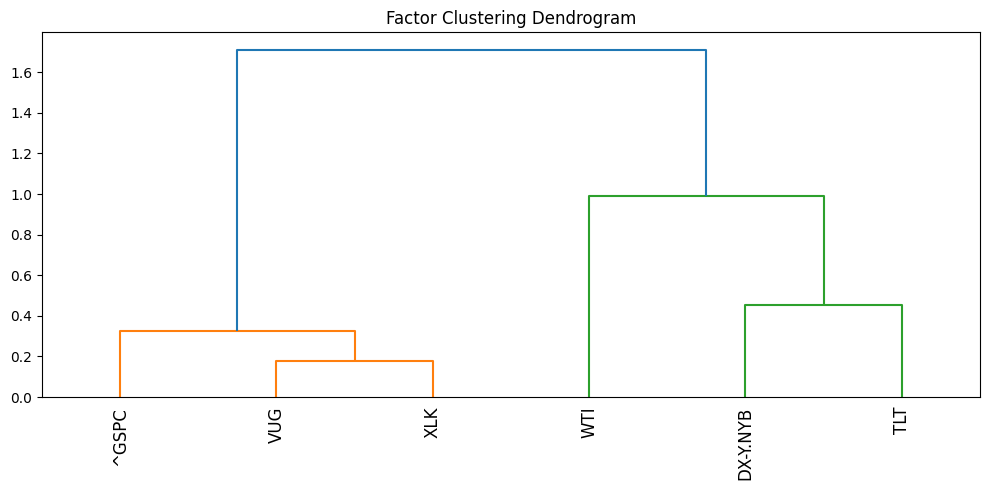

In [146]:
'''
Visualization of the Top 3 Largest PCs on Portfolio, and what they are composed of in regards to Market Factors.
'''
from scipy.cluster.hierarchy import linkage, fcluster

def cluster_factors(factor_market_correlation, method="ward", metric="euclidean", max_clusters=None):
    factor_profiles = factor_market_correlation.T.values  # shape: factors x PCs
    Z = linkage(factor_profiles, method=method, metric=metric)

    if max_clusters:
        labels = fcluster(Z, max_clusters, criterion="maxclust")
    else:
        labels = fcluster(Z, t=1.0, criterion="inconsistent")

    clusters = {}
    for factor, label in zip(factor_market_correlation.columns, labels):
        clusters.setdefault(label, []).append(factor)

    return clusters, Z

clusters, Z = cluster_factors(factor_market_correlation)

from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt


def plot_dendrogram(Z, factor_names, title="Factor Clustering Dendrogram"):
    """
    Plots dendrogram of factor clustering.
    """
    plt.figure(figsize=(10, 5))
    dendrogram(Z, labels=factor_names, leaf_rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Call plot_dendrogram with the linkage matrix Z and the original factor names
plot_dendrogram(Z, factor_market_correlation.columns)

# Risk Findings

In this section I map out what the clustering along with the market factors correlating with the PCs mean for the portfolio.


The total variance of the portfolio is, 1.630608e-04 when compared to the factor contributions we find that much of this stems from k=3, ['PC1' 'PC2' 'PC3']: covering 77.4% of total variance.
Absolute Factor Contributions (Scaled in Proportion of Total Port Var) for Top K PCs:
  PC1: 1.481836e-04
  PC2: 3.085664e-06
  PC3: 9.528703e-06
Relative Factor Contribution ratios (% of Total Port Var) for Top K PCs:
  PC1: 0.9088
  PC2: 0.0189
  PC3: 0.0584

--- Asset Risk Sheet (Top 3 PCs, Cumulative Returns) ---


,Weight,PC1,PC2,PC3,PC1_CumReturn,PC2_CumReturn,PC3_CumReturn
Ticker,,,,,,,
AAPL,0.1,-0.245117,-0.096219,0.201255,-0.973809,-0.81217,-0.115034
AMZN,0.1,-0.325648,-0.234500,0.313741,-0.973809,-0.81217,-0.115034
GOOGL,0.1,-0.270596,-0.231481,0.298540,-0.973809,-0.81217,-0.115034
JNJ,0.1,-0.008745,-0.024629,0.201777,-0.973809,-0.81217,-0.115034
JPM,0.1,-0.117823,-0.047551,0.331480,-0.973809,-0.81217,-0.115034
MSFT,0.1,-0.244996,-0.204128,0.148251,-0.973809,-0.81217,-0.115034
NVDA,0.1,-0.544856,-0.479351,-0.572327,-0.973809,-0.81217,-0.115034
PG,0.1,-0.026791,-0.053157,0.159904,-0.973809,-0.81217,-0.115034
TSLA,0.1,-0.622199,0.776421,-0.038127,-0.973809,-0.81217,-0.115034


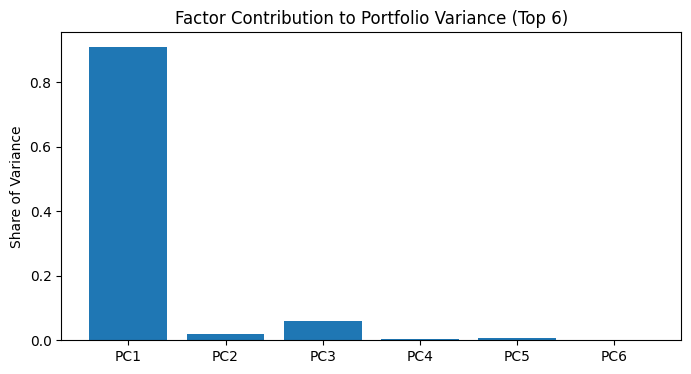

In [147]:
'''
Summary of PCS that were found and how much they impact the Portfolio.
'''

print(f"The total variance of the portfolio is, {port_var:.6e} when compared to the factor contributions we find that much of this stems from k={k}, {topk_load.columns.values}: covering {cum[k-1]:.1%} of total variance.")

print("Absolute Factor Contributions (Scaled in Proportion of Total Port Var) for Top K PCs:")
# Iterate only up to k for absolute contributions
for i in range(k):
    print(f"  PC{i+1}: {pc_risk_contrib[i]:.6e}")

print("Relative Factor Contribution ratios (% of Total Port Var) for Top K PCs:")
# Iterate only up to k for relative contributions
for i in range(k):
    print(f"  PC{i+1}: {factor_contrib_ratio[i]:.4f}")


if 'weights' in locals() and 'cols' in locals() and 'factor_loadings' in locals() and 'factor_returns' in locals():
    asset_weights_df = pd.DataFrame({'Weight': weights}, index=cols)

    # Select loadings for PC1, PC2, and PC3
    top3_loadings = factor_loadings[['PC1', 'PC2', 'PC3']].copy()

    # --- Use cumulative returns instead of latest ---
    # factor_returns is assumed to be daily returns of PCs
    cumulative_factor_returns = (1 + factor_returns[['PC1', 'PC2', 'PC3']]).cumprod() - 1
    cum_returns = cumulative_factor_returns.iloc[-1].rename("Cumulative Factor Return").to_frame().T

    # Repeat for each asset so we can merge cleanly
    cum_returns_repeated = cum_returns.loc[cum_returns.index.repeat(len(cols))]
    cum_returns_repeated.index = cols

    # Build the risk sheet
    risk_sheet_df = asset_weights_df.copy()
    risk_sheet_df = risk_sheet_df.join(top3_loadings)

    # Rename cumulative return columns
    cum_returns_repeated.columns = [f"{col}_CumReturn" for col in cum_returns_repeated.columns]
    risk_sheet_df = risk_sheet_df.join(cum_returns_repeated)

    print("\n--- Asset Risk Sheet (Top 3 PCs, Cumulative Returns) ---")
    display(risk_sheet_df)

else:
    print("\nRequired data (weights, cols, factor_loadings, factor_returns) not available. Please run the relevant cells.")

# --- Factor contribution bar chart ---
plt.figure(figsize=(8,4))
plt.bar([f"PC{i+1}" for i in range(6)], factor_contrib_ratio[:6])
plt.title("Factor Contribution to Portfolio Variance (Top 6)")
plt.ylabel("Share of Variance")
plt.show()


PC1 (Top 5 Market Factors)
     Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
0       VUG               0.913387            0.527829            0.482112
1       XLK               0.878431            0.527829            0.463661
2     ^GSPC               0.839519            0.527829            0.443122
3  DX-Y.NYB               0.269192            0.527829            0.142087
4       WTI               0.146543            0.527829            0.077349

PC2 (Top 5 Market Factors)
      Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
6        XLK               0.308297             0.16044            0.049463
7        VUG               0.260387             0.16044            0.041777
8      ^GSPC               0.254336             0.16044            0.040806
9   DX-Y.NYB               0.070745             0.16044            0.011350
10       WTI               0.037281             0.16044            0.005981

PC3 (Top 5 Market Factors)
      Fact

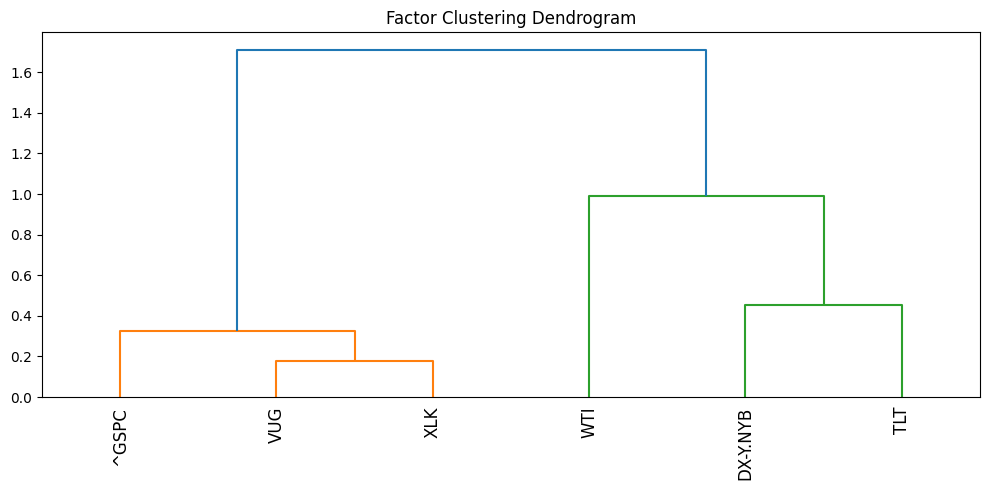

In [148]:
'''
Summary of PCs Relating to Market Factors
'''
for pc, df in pc_breakdowns.items():
    print(f"\n{pc} (Top 5 Market Factors)")
    print(df)

if 'Z' in locals() and 'factor_market_correlation' in locals():

  plot_dendrogram(Z, factor_market_correlation.columns)
else:
    print("\nRequired data (Z, factor_market_correlation) for dendrogram not available. Please run the relevant cells.")

# Portfolio Reconstruction

This section focuses on rebuilding portfolio with PC loadings in mind to minimize risks involved by hedging through a regression engine.

In [149]:
'''
Portfolio Exposure to PCs
'''
exposure = topk_load
print('Portfolio Assets Exposure PCs:')
print(exposure)

Portfolio Assets Exposure PCs:
             PC1       PC2       PC3
Ticker                              
AAPL   -0.245117 -0.096219  0.201255
AMZN   -0.325648 -0.234500  0.313741
GOOGL  -0.270596 -0.231481  0.298540
JNJ    -0.008745 -0.024629  0.201777
JPM    -0.117823 -0.047551  0.331480
MSFT   -0.244996 -0.204128  0.148251
NVDA   -0.544856 -0.479351 -0.572327
PG     -0.026791 -0.053157  0.159904
TSLA   -0.622199  0.776421 -0.038127
XOM    -0.044162 -0.046905  0.494756


In [150]:
for pc, df in pc_breakdowns.items():
    print(f"\n{pc} (Top 5 Market Factors)")
    print(df)


PC1 (Top 5 Market Factors)
     Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
0       VUG               0.913387            0.527829            0.482112
1       XLK               0.878431            0.527829            0.463661
2     ^GSPC               0.839519            0.527829            0.443122
3  DX-Y.NYB               0.269192            0.527829            0.142087
4       WTI               0.146543            0.527829            0.077349

PC2 (Top 5 Market Factors)
      Factor  Absolute Correlation:  Variance_Explained  Weighted_Influence
6        XLK               0.308297             0.16044            0.049463
7        VUG               0.260387             0.16044            0.041777
8      ^GSPC               0.254336             0.16044            0.040806
9   DX-Y.NYB               0.070745             0.16044            0.011350
10       WTI               0.037281             0.16044            0.005981

PC3 (Top 5 Market Factors)
      Fact

In [151]:
import statsmodels.api as sm

portfolio_returns = (returns * weights).sum(axis=1)
common_index = returns.index.intersection(market_returns.index)
portfolio_returns = portfolio_returns.reindex(common_index)
market_returns_aligned = market_returns.reindex(common_index)
portfolio_notional = 1_000_000

In [152]:

top_market_factors_to_hedge = influence_df['Factor'].tolist()


for factor in top_market_factors_to_hedge:

    common_index = portfolio_returns.index.intersection(market_returns_aligned[factor].dropna().index)
    portfolio_returns_aligned = portfolio_returns.reindex(common_index)
    market_factor_returns_aligned = market_returns_aligned[factor].reindex(common_index)

    X = sm.add_constant(market_factor_returns_aligned)


    model = sm.OLS(portfolio_returns_aligned, X).fit()

    beta_factor = model.params[factor]

    print(f"Regression beta to {factor}: {beta_factor}")

Regression beta to VUG: 0.8763760902271226
Regression beta to XLK: 0.7745888757970089
Regression beta to ^GSPC: 1.154253420898628
Regression beta to DX-Y.NYB: -0.9135894842569541
Regression beta to WTI: 0.0733444400089275
Regression beta to TLT: 0.0507621918720089


In [153]:

hedge_amounts = {}

top_market_factors_to_hedge = influence_df['Factor'].tolist()


for factor in top_market_factors_to_hedge:

    common_index = portfolio_returns.index.intersection(market_returns.index)
    portfolio_returns_aligned = portfolio_returns.reindex(common_index).dropna()
    market_factor_returns_aligned = market_returns[factor].reindex(common_index).dropna()

    common_index_clean = portfolio_returns_aligned.index.intersection(market_factor_returns_aligned.index)
    portfolio_returns_aligned = portfolio_returns_aligned.reindex(common_index_clean)
    market_factor_returns_aligned = market_factor_returns_aligned.reindex(common_index_clean)

    X = sm.add_constant(market_factor_returns_aligned)
    model = sm.OLS(portfolio_returns_aligned, X).fit()
    beta_factor = model.params[factor]

    latest_factor_data = yf.download(factor, start=common_index_clean[-1], end=common_index_clean[-1] + pd.Timedelta(days=1), auto_adjust=False)['Adj Close']
    latest_factor_price = latest_factor_data.iloc[-1].item()
    hedge_amount = beta_factor * portfolio_notional / latest_factor_price
    hedge_amounts[factor] = hedge_amount

print("\nCalculated Hedge Amounts (approximate shares to short/long):")
for factor, amount in hedge_amounts.items():
    print(f"  {factor}: {amount:.2f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Calculated Hedge Amounts (approximate shares to short/long):
  VUG: 2121.09
  XLK: 3314.86
  ^GSPC: 195.41
  DX-Y.NYB: -8448.99
  WTI: 44769.42
  TLT: 595.18


In [154]:
print("\nCalculated Hedge Amounts (approximate shares to short/long for hedging):")
for factor, amount in hedge_amounts.items():
    print(f"  {factor}: {amount:.2f}")


Calculated Hedge Amounts (approximate shares to short/long for hedging):
  VUG: 2121.09
  XLK: 3314.86
  ^GSPC: 195.41
  DX-Y.NYB: -8448.99
  WTI: 44769.42
  TLT: 595.18


# Hedge VS Directionality Portfolio Performance


In [166]:
initial_portfolio_returns_daily = (returns * weights).sum(axis=1)
initial_portfolio_cumulative_returns = (1 + initial_portfolio_returns_daily).cumprod() - 1
initial_portfolio_value = portfolio_notional * (1 + initial_portfolio_cumulative_returns)


,0
Date,
2021-01-05,1.013104e+06
2021-01-06,1.009307e+06
2021-01-07,1.036091e+06
2021-01-08,1.047943e+06
2021-01-11,1.037413e+06


In [168]:
hedge_portfolio_value = {}

for factor, amount in hedge_amounts.items():
    factor_returns_aligned = market_returns[factor].reindex(portfolio_returns.index).dropna()
    portfolio_returns_aligned = portfolio_returns.reindex(factor_returns_aligned.index)
    latest_factor_price = yf.download(factor, start=factor_returns_aligned.index[-1], end=factor_returns_aligned.index[-1] + pd.Timedelta(days=1), auto_adjust=False)['Adj Close'].iloc[-1].item()
    hedge_notional = abs(amount) * latest_factor_price
    if amount < 0: # Short position
        daily_hedge_value = hedge_notional * (1 - factor_returns_aligned).cumprod()
    else: # Long position
        daily_hedge_value = hedge_notional * (1 + factor_returns_aligned).cumprod()

    hedge_portfolio_value[factor] = daily_hedge_value

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [170]:
hedged_portfolio_value = initial_portfolio_value.copy()
for factor, daily_hedge_values in hedge_portfolio_value.items():
    aligned_daily_hedge_values = daily_hedge_values.reindex(hedged_portfolio_value.index)

    # Determine if the hedge is a short or long position
    is_short = hedge_amounts[factor] < 0

    # Add or subtract the daily hedge values based on the position
    if is_short:
        hedged_portfolio_value -= aligned_daily_hedge_values
    else:
        hedged_portfolio_value += aligned_daily_hedge_values

In [171]:
import yfinance as yf
from datetime import datetime, timedelta

last_historical_date = returns.index[-1]
real_time_start_date = last_historical_date + timedelta(days=1)

all_tickers = list(returns.columns) + list(market_returns.columns)
all_tickers = list(set(all_tickers)) # Get unique tickers

real_time_data = yf.download(all_tickers, start=real_time_start_date.strftime('%Y-%m-%d'), end=datetime.now().strftime('%Y-%m-%d'), auto_adjust=False)['Adj Close']

display(real_time_data.head())

[*********************100%***********************]  16 of 16 completed


Ticker,AAPL,AMZN,DX-Y.NYB,GOOGL,JNJ,JPM,MSFT,NVDA,PG,TLT,TSLA,VUG,WTI,XLK,XOM,^GSPC
Date,,,,,,,,,,,,,,,,
2025-01-02,242.987411,220.220001,109.389999,188.814438,140.629639,236.167389,416.292511,138.287674,162.838470,85.065758,379.279999,408.632812,1.746181,231.180283,104.416374,5868.549805
2025-01-03,242.499161,224.190002,108.949997,191.166748,140.795639,239.395020,421.036469,144.446686,162.004578,84.793770,410.440002,415.475922,1.726561,234.947418,104.951546,5942.470215
2025-01-06,244.133347,227.610001,108.260002,196.230255,140.278107,238.227875,425.511871,149.405869,157.560318,84.414917,411.049988,420.174316,1.618651,237.937195,104.834785,5975.379883
2025-01-07,241.353226,222.110001,108.540001,194.854752,142.787613,240.522598,420.061798,140.117371,158.247055,83.462944,394.359985,412.054352,1.599031,233.163513,105.817543,5909.029785
2025-01-08,241.841492,222.130005,109.089996,193.319748,138.920837,240.483047,422.239807,140.087387,159.031906,83.569801,394.940002,412.672821,1.677511,233.083786,104.046623,5918.250000


In [173]:
real_time_asset_returns = np.log(real_time_data[returns.columns] / real_time_data[returns.columns].shift(1)).dropna()
real_time_market_returns = np.log(real_time_data[market_returns.columns] / real_time_data[market_returns.columns].shift(1)).dropna()
real_time_original_portfolio_returns_daily = (real_time_asset_returns * weights).sum(axis=1)

In [174]:
initial_portfolio_value_real_time = initial_portfolio_value.iloc[-1] * (1 + real_time_original_portfolio_returns_daily).cumprod()

hedge_portfolio_value_real_time = {}
for factor, amount in hedge_amounts.items():
    factor_returns_real_time = real_time_market_returns[factor]
    last_historical_hedge_value = hedge_portfolio_value[factor].iloc[-1]
    if amount < 0: # Short position
        daily_hedge_value_real_time = last_historical_hedge_value * (1 - factor_returns_real_time).cumprod()
    else: # Long position
        daily_hedge_value_real_time = last_historical_hedge_value * (1 + factor_returns_real_time).cumprod()
    hedge_portfolio_value_real_time[factor] = daily_hedge_value_real_time

hedged_portfolio_value_real_time = initial_portfolio_value_real_time.copy()

for factor, daily_hedge_values_real_time in hedge_portfolio_value_real_time.items():
    aligned_daily_hedge_values_real_time = daily_hedge_values_real_time.reindex(hedged_portfolio_value_real_time.index)
    is_short = hedge_amounts[factor] < 0
    if is_short:
        hedged_portfolio_value_real_time -= aligned_daily_hedge_values_real_time
    else:
        hedged_portfolio_value_real_time += aligned_daily_hedge_values_real_time

In [177]:
complete_original_portfolio_value = pd.concat([initial_portfolio_value, initial_portfolio_value_real_time])
hedged_portfolio_value.iloc[0] = initial_portfolio_value.loc[hedged_portfolio_value.index[0]]

complete_hedged_portfolio_value = pd.concat([hedged_portfolio_value, hedged_portfolio_value_real_time])

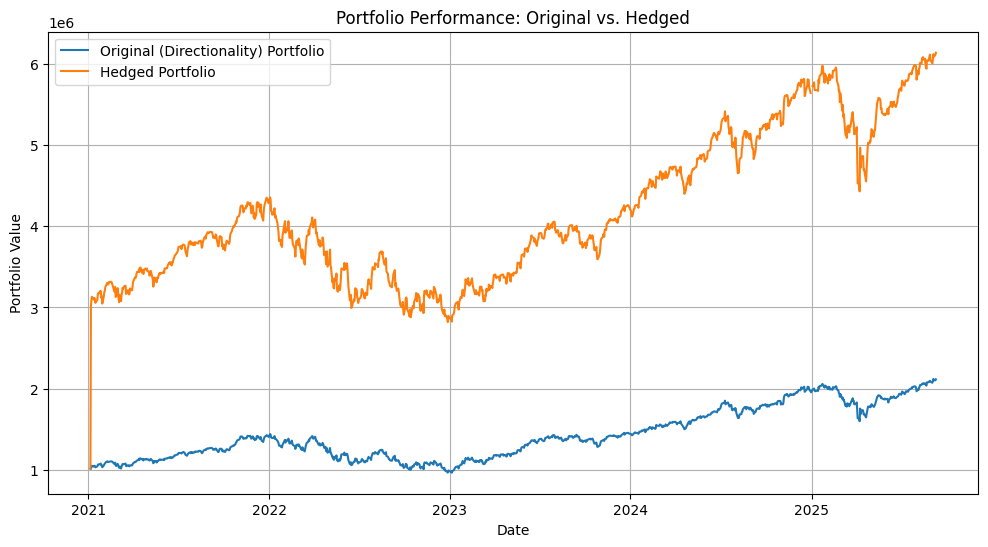

Original Portfolio Total Return: 1.0857
Hedged Portfolio Total Return: 5.0611
Original Portfolio Annualized Volatility: 0.2086
Hedged Portfolio Annualized Volatility: 0.9462


In [178]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(complete_original_portfolio_value, label='Original (Directionality) Portfolio')
first_valid_date = complete_hedged_portfolio_value.first_valid_index()
if first_valid_date:
    initial_hedged_value = initial_portfolio_value.loc[first_valid_date]
    scaled_hedged_portfolio_value = complete_hedged_portfolio_value / complete_hedged_portfolio_value.loc[first_valid_date] * initial_hedged_value
    ax.plot(scaled_hedged_portfolio_value, label='Hedged Portfolio')
else:
     ax.plot(complete_hedged_portfolio_value, label='Hedged Portfolio')

ax.set_title('Portfolio Performance: Original vs. Hedged')
ax.set_ylabel('Portfolio Value')
ax.set_xlabel('Date')
ax.legend()
ax.grid(True)
plt.show()

original_total_return = (complete_original_portfolio_value.iloc[-1] / complete_original_portfolio_value.iloc[0]) - 1
if first_valid_date:
    hedged_total_return = (scaled_hedged_portfolio_value.iloc[-1] / scaled_hedged_portfolio_value.iloc[0]) - 1
else:
    hedged_total_return = (complete_hedged_portfolio_value.iloc[-1] / complete_hedged_portfolio_value.iloc[0]) - 1

original_daily_returns = complete_original_portfolio_value.pct_change(fill_method=None).dropna()

if first_valid_date:
    hedged_daily_returns = scaled_hedged_portfolio_value.pct_change(fill_method=None).dropna()
else:
    hedged_daily_returns = complete_hedged_portfolio_value.pct_change(fill_method=None).dropna()


original_volatility = original_daily_returns.std() * np.sqrt(252) # Annualized volatility
hedged_volatility = hedged_daily_returns.std() * np.sqrt(252)   # Annualized volatility

print(f"Original Portfolio Total Return: {original_total_return:.4f}")
print(f"Hedged Portfolio Total Return: {hedged_total_return:.4f}")
print(f"Original Portfolio Annualized Volatility: {original_volatility:.4f}")
print(f"Hedged Portfolio Annualized Volatility: {hedged_volatility:.4f}")